<a href="https://colab.research.google.com/github/RaulAtLehigh/CSE337_P1/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make('MountainCar-v0', max_episode_steps = 500)
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters for DQN
gamma = 0.99 # Discount factor for future rewards
alpha = 0.001 # Learning rate for the optimizer
epsilon = .5 # Initial epsilon for epsilon-greedy policy
epsilon_min = 0.01 # Minimum epsilon
epsilon_decay = 0.95 # Epsilon decay rate
num_episodes = 1000 # Total number of training episodes
batch_size = 64 # Size of the batch sampled from the replay buffer
replay_buffer_size = 50000 # Maximum size of the replay buffer

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define Q-Network using a simple MLP
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        # First fully connected layer: state_dim -> 64 neurons
        self.fc1 = nn.Linear(state_dim, 64) # 2 -> 64
        # Second fully connected layer: 64 -> 64 neurons
        self.fc2 = nn.Linear(64, 64)
        # Third fully connected layer: 64 -> n_actions (output Q-values for each action)
        self.fc3 = nn.Linear(64, n_actions) #(64 -> 3)

    def forward(self, x):
        # Apply ReLU activation after the first two layers
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Output layer (no activation for Q-values)
        return self.fc3(x)

In [ ]:
# Initialize the Q-network and move it to the selected device
q_net = QNetwork(state_dim, n_actions).to(device)
# Initialize the Adam optimizer with the Q-network parameters and learning rate
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
# Define the loss function as Mean Squared Error (MSE)
loss_fn = nn.MSELoss()
# Initialize the replay buffer as a deque with a maximum size
replay_buffer = deque(maxlen=replay_buffer_size)

In [ ]:
def epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
      # making state into a tensor
      state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
      with torch.no_grad(): # disable the gradient calculation
          q_values = q_net(state_tensor) # get the q value
      # .max(1) returns (max_values, max_indices) along dimension 1 (actions)
      # [1] to get the indices, and .item() to extract the scalar index
      return q_values.max(1)[1].item()

In [ ]:
def train_dqn():
    """Train the DQN using experience replay."""
    # Only start training if the replay buffer has enough samples
    if len(replay_buffer) < batch_size:
        return

    # Sample a random mini-batch of transitions from the replay buffer
    batch = random.sample(replay_buffer, batch_size)
    # Unzip the batch into separate tensors for states, actions, rewards, next_states, and dones
    states, actions, rewards, next_states, dones = zip(*batch)

    # Convert lists of numpy arrays to PyTorch tensors and move them to the device
    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Compute the predicted Q-values for the taken actions
    # q_net(states) gives Q-values for all actions in the current states
    # .gather(1, actions.unsqueeze(1)) selects the Q-value for the action taken in each state
    # .squeeze(1) removes the unnecessary dimension
    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # Compute the maximum predicted Q-value for the next states
    # q_net(next_states) gives Q-values for all actions in the next states
    # .max(1)[0] gets the maximum Q-value among all actions for each next state
    # .detach() stops the gradient from flowing back through the target
    next_q_values = q_net(next_states).max(1)[0].detach()

    # Compute the target Q-values using the Bellman equation
    # If done, target is just the reward
    # Otherwise, target is reward + gamma * max Q(next_state, action)
    targets = rewards + gamma * next_q_values * (1 - dones)

    # Compute the Mean Squared Error loss between the predicted Q-values and the target Q-values
    loss = loss_fn(q_values, targets)

    # Perform backpropagation
    optimizer.zero_grad() # Clear previous gradients
    loss.backward() # Compute gradients
    optimizer.step() # Update network weights

In [ ]:
## MAIN Loop ###
rewards_dqn = []
N = 25 # Every 25 episodes, performing greedy policy

for episode in range(num_episodes):
  state = env.reset()[0]
  total_reward = 0
  done = False
  stepCount = 0
  actionCount = [0, 0, 0]
  while not done and stepCount < 500:
    stepCount += 1
    action = epsilon_greedy(state, epsilon) if episode % N != 0 else epsilon_greedy(state, 0) # greedy policy every N episodes
    actionCount[action] += 1
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.append((state, action, reward, next_state,done))
    train_dqn()
    state = next_state
    total_reward += reward
  rewards_dqn.append(total_reward)
  #going to implement epsilon decay since I need to explore WAYY more than I thought I did
  print(f'Total Reward after episode {episode}: {total_reward}\n Epsilon = {epsilon}\n  Left: {actionCount[0]}\n  Stay: {actionCount[1]}\n  Right: {actionCount[2]}')
  epsilon = epsilon * epsilon_decay if epsilon >= epsilon_min else epsilon_min

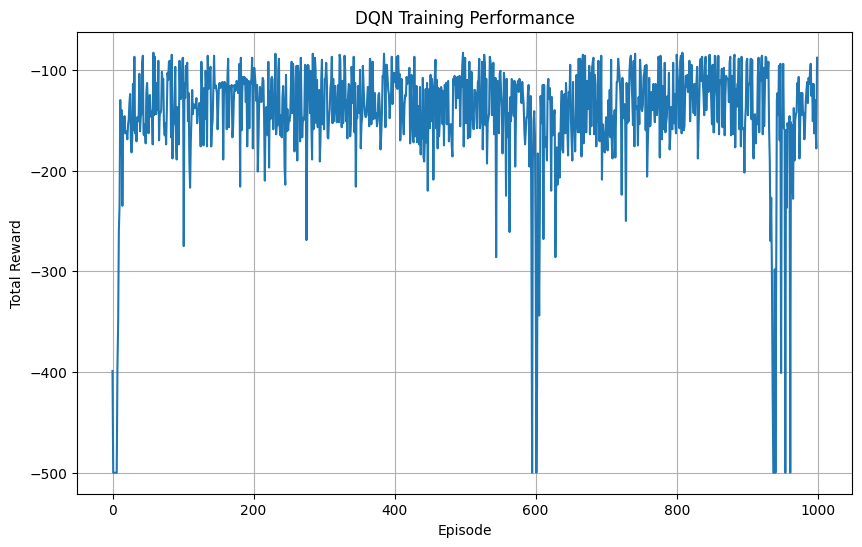

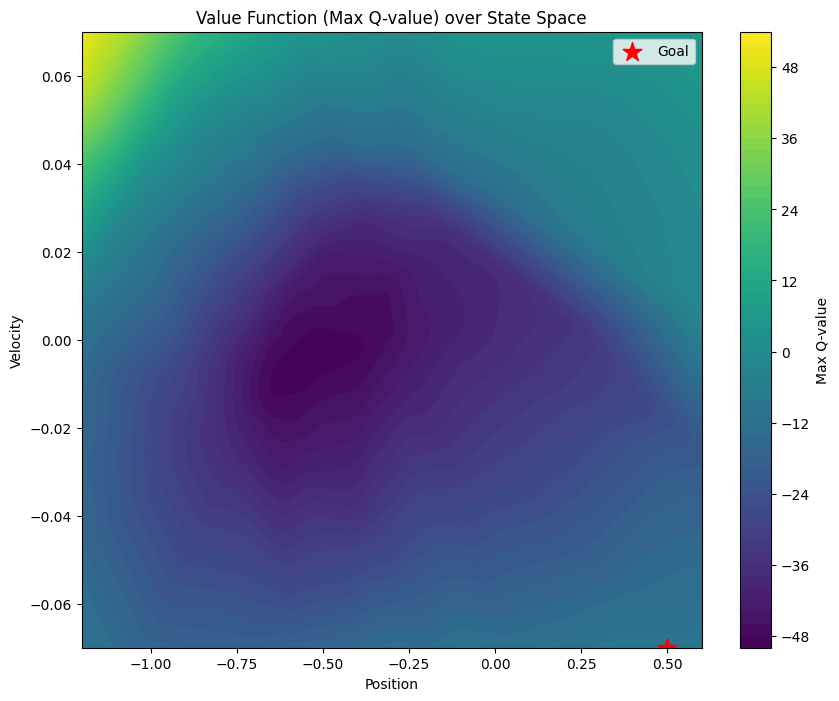

In [ ]:
# Plotting the episode returns
plt.figure(figsize=(10, 6))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance")
plt.grid(True)
plt.show()

# Plotting the value function
# Create a grid of state space (position and velocity)
# Generate 50 points for position between the min and max values
# Generate 50 points for velocity between the min and max values
position_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 50)
velocity_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 50)

# Create a meshgrid from the position and velocity arrays to get all combinations
pos_mesh, vel_mesh = np.meshgrid(position_space, velocity_space)

# Flatten the meshgrids and stack them to create a list of all state combinations
state_grid = np.stack([pos_mesh.flatten(), vel_mesh.flatten()], axis=1)

# Convert the state grid to a PyTorch tensor
state_grid_tensor = torch.FloatTensor(state_grid).to(device)

# Get the maximum Q-value for each state in the grid using the trained q_net
# .max(1)[0] gets the maximum value along dimension 1 (actions)
with torch.no_grad(): # disable gradient calculations
    q_values_grid = q_net(state_grid_tensor).max(1)[0].cpu().numpy() # move back to cpu

# Reshape the Q-values back into a 2D grid matching the meshgrid dimensions
value_function = q_values_grid.reshape(pos_mesh.shape)

# Create a contour plot of the value function
plt.figure(figsize=(10, 8))
# Use 'viridis' colormap, and specify the levels for the contour lines
contour = plt.contourf(pos_mesh, vel_mesh, value_function, levels=50, cmap='viridis')
plt.colorbar(contour, label="Max Q-value") # Add a color bar to show the mapping between colors and values

# Add labels and title to the plot
plt.xlabel("Position")
plt.ylabel("Velocity")
plt.title("Value Function (Max Q-value) over State Space")

# Add the goal state as a point on the plot
# MountainCar goal is at position 0.5
plt.scatter(0.5, env.observation_space.low[1], color='red', marker='*', s=200, label="Goal") # Mark the goal position

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

**Discussion**


With an alpha value of 0.01, deep q learning was actually able to learn at the same rate as the tile/SARSA exercise from last lab with an alpha of .125 and 8 tiles. However, when I used 4x4 tiles last class and had a higher alpha value, the agent was able to learn to hit the goal consistently in under 10 episodes.

Actually, now that I reran my model I'm facing stability issues where the model takes over 500 episodes to even reach the goal which changes my answer to the next question. In terms of stability, I did find the tile method to offer more stability, in the sense that it did not need as much exploration as my DQN model. Overtime, this exploration (with a higher epsilon value) makes it so that my model (sort of) ignores an optimal path.

For generalization, I'd have to say it depends. A tiling example can increase generalization by decreasing the number of tiles used in the sample space, whereas the neural network could decrease the number of nodes in the hidden layers. From a programmer's perspective, it's much easier to see how a tile system performs generalization, but the neural network is much more cryptic.

I found that I had to tune this model much more, but this was due to my lack of experience. I was training at very high alpha values since I was used to the linear methods, however, I learned that neural networks benefit from smaller learning rates.

# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?


In [ ]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

env = gym.make('LunarLander-v3')
n_actions = env.action_space.n # there are 4 actions possible in this env
state_dim = env.observation_space.shape[0] # state dimension is 8

gamma = 0.99
alpha = 0.001
epsilon = .5
epsilon_min = 0.01
epsilon_decay = 0.95
num_episodes = 1000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Q-Network using a simple MLP
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(state_dim, 128) # 8 -> 128
        ## going to try and add another hidden layer, just for fun
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_actions) #(64 -> 4)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        # Output layer (no activation for Q-values)
        return self.fc4(x)

# Building QNetwork
q_net = QNetwork(state_dim, n_actions).to(device)
q_net_copy = QNetwork(state_dim, n_actions).to(device) # target network
optimizer = optim.Adam(q_net.parameters(), lr=alpha) # adam optimizer (improves learning rate)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)

# Epsilon-greedy action selection
def epsilon_greedy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
      # making state into a tensor
      state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
      with torch.no_grad():
          q_values = q_net(state_tensor)
      return q_values.max(1)[1].item()

def train_dqn():
    """Train the DQN using experience replay."""
    if len(replay_buffer) < batch_size:
        return

    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    """Should I calculate next_q_values using q_net or q_net_copy?
    I think I should use q_net_copy, since it is more stable."""
    next_q_values = q_net_copy(next_states).max(1)[0].detach()

    targets = rewards + gamma * next_q_values * (1 - dones)

    # Compute the Mean Squared Error loss between the predicted Q-values and the target Q-values
    loss = loss_fn(q_values, targets)

    # Perform backpropagation
    optimizer.zero_grad() # Clear previous gradients
    loss.backward() # Compute gradients
    optimizer.step() # Update network weights

# function to update target network
def update_target_network():
    q_net_copy.load_state_dict(q_net.state_dict()) # load the current state of the main network into the target network
    q_net_copy.eval() # set target network to evaluation mode

# Training loop
## MAIN Loop ###
rewards_dqn = []
target_network_update_freq = 10 # update target network every 10 episodes

for episode in range(num_episodes):
  if episode % target_network_update_freq == 0:
    update_target_network()
  state = env.reset()[0]
  total_reward = 0
  done = False
  stepCount = 0
  while not done and stepCount < 500:
    stepCount += 1
    action = epsilon_greedy(state, epsilon)
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.append((state, action, reward, next_state,done))
    train_dqn()
    state = next_state
    total_reward += reward
  rewards_dqn.append(total_reward)
  #going to implement epsilon decay since I need to explore WAYY more than I thought I did
  #print(f'Total Reward after episode {episode}: {total_reward}')
  epsilon = epsilon * epsilon_decay if epsilon >= epsilon_min else epsilon_min




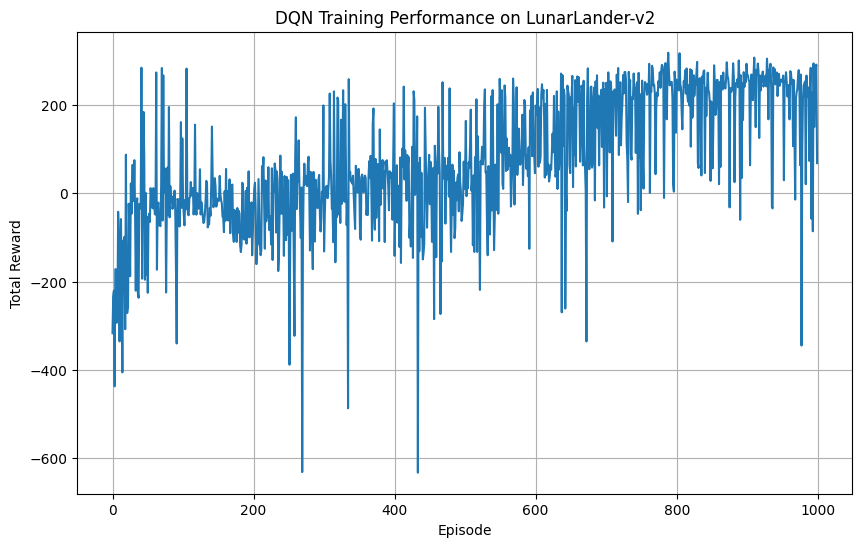

Evaluation Episode 0: Total Reward = 252.12399955064123
Evaluation Episode 1: Total Reward = 242.78793902222486
Evaluation Episode 2: Total Reward = 245.78728439657746
Evaluation Episode 3: Total Reward = -162.31499292901273
Evaluation Episode 4: Total Reward = 267.14255726639874
Evaluation Episode 5: Total Reward = 265.9686804780343
Evaluation Episode 6: Total Reward = -158.44704821615386
Evaluation Episode 7: Total Reward = -8.691564336102786
Evaluation Episode 8: Total Reward = 247.75400968808574
Evaluation Episode 9: Total Reward = 1.1571585937468996


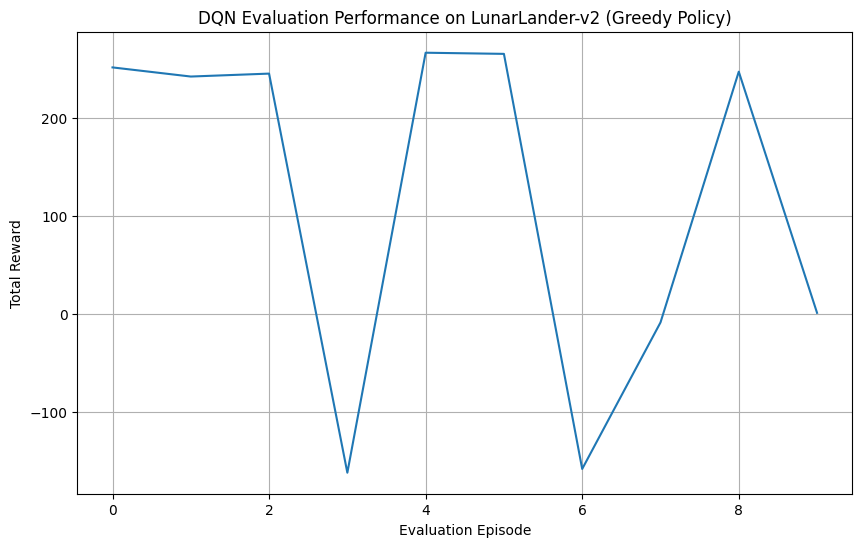


Average reward over 10 evaluation episodes: 119.326802351444


In [4]:
# Plotting the episode returns
plt.figure(figsize=(10, 6))
plt.plot(rewards_dqn)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Performance on LunarLander-v3")
plt.grid(True)
plt.show()

# Evaluation with a greedy policy (epsilon = 0)
eval_episodes = 10
eval_rewards = []

for episode in range(eval_episodes):
    state = env.reset()[0]
    total_reward = 0
    done = False
    while not done:
        # Greedy action selection
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action = q_net(state_tensor).max(1)[1].item()

        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        total_reward += reward
    eval_rewards.append(total_reward)
    print(f"Evaluation Episode {episode}: Total Reward = {total_reward}")

# Plotting the evaluation performance
plt.figure(figsize=(10, 6))
plt.plot(eval_rewards)
plt.xlabel("Evaluation Episode")
plt.ylabel("Total Reward")
plt.title("DQN Evaluation Performance on LunarLander-v3 (Greedy Policy)")
plt.grid(True)
plt.show()

average_eval_reward = np.mean(eval_rewards)
print(f"\nAverage reward over {eval_episodes} evaluation episodes: {average_eval_reward}")

After Episode 550, my model was able to learn how to achieve high rewards consistently. This took longer than I expected, but it also makes sense since I started with a high epsilon rate and decayed over time. During the initial exploration phases, I saw the lander actually land perfectly a couple times which was very impressive (being that this was near random policy). These exploration phases boosted my model so that at the point where I was using mostly-greedy, it was able to have a lot of data to sample (in the batches) and build its q-values on.

While I didn’t play too much with the replay buffer, I can imagine that a higher buffer can hurt at some point as we have a higher chance to sample from non-ideal state/reward pairs that our model has actually learned out of. For target update-frequency, this actually improved the stability of my model since I had actually set it to update every 10 episodes. This means that between this range, our model was facing no updates in the q-value which I think was actually good for generalization. The learning rate itself was handled by the optimizer, but I had to learn that smaller learning rates provide more stability across continuous spaces like this one.

This example is similar to my experiments with the previous environment since it took some fine tuning since it failed to converge for lower epsilon values, and higher alpha values.

In LunarLander, the state space is much more challenging to learn for the neural network. The fact that maximizing rewards could be done in different ways like using less propulsion and landing in the spot correctly means that the model had to learn the most optimal way to get there (in Lunar Lander). Vs. in Mountain car, there was a more clear value function.

I think DQN is for sure necessary here because something like this would be very difficult to model with tiles. While we can clearly see a measurable way to get to the correct position, a computer with the bias of tiling and 2 dimensional space is probably going to get confused on what it did wrong wand where to change its behavior for future episodes.
